In [1]:
import sys
sys.path.append('../python')
import pandas as pd
pd.options.display.max_rows = 50
pd.options.display.max_columns = 50
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import IPython
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
from util import *

/Users/Ren.Zhang@ibm.com/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_files = get_training_label_wavfilename(fullset=True)
test_files = get_test_wavefilename()

In [3]:
train_files.groupby('label').size().reset_index().T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
label,bed,bird,cat,dog,down,eight,five,four,go,happy,house,left,marvin,nine,no,off,on,one,right,seven,sheila,silence,six,stop,three,tree,two,up,wow,yes,zero
0,1713,1731,1733,1746,2359,2352,2357,2372,2372,1742,1750,2353,1746,2364,2375,2357,2367,2370,2367,2377,1734,2400,2369,2380,2356,1733,2373,2375,1745,2377,2376


In [4]:
# train_samples = train_files.loc[train_files['label'] != 'silence'].sample(4000)
train_samples = train_files.sample(4000)
test_samples = test_files.sample(4000)

In [5]:
d_train = np.array([
    signal.resample(
        read_wav_sample('../input/train/audio/{}/{}'.format(row['label'], row['filename'])),
        8000
    ) / 32768
    for _, row in train_samples.iterrows()]
)

d_test = np.array([
    signal.resample(
        read_wav_sample('../input/test/audio/{}'.format(row['fname'])),
        8000
    ) / 32768
    for _, row in test_samples.iterrows()]
)

In [6]:
%%time
pca = PCA(n_components=600, random_state=42).fit(d_train)

CPU times: user 25.5 s, sys: 886 ms, total: 26.4 s
Wall time: 6.04 s


In [7]:
sum(pca.explained_variance_ratio_)

0.8148691013882241

In [8]:
pcs = pca.transform(np.vstack([d_train, d_test]))

In [9]:
%%time
tsne = TSNE(n_components=2, init='pca', n_iter=1000, verbose=1)
Y = tsne.fit_transform(pcs)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.165s...
[t-SNE] Computed neighbors for 8000 samples in 79.413s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.110886
[t-SNE] Error after 1000 iterations: 2.925681
CPU times: user 6min 12s, sys: 19.9 s, total: 6min 32s
Wall time: 6min 34s


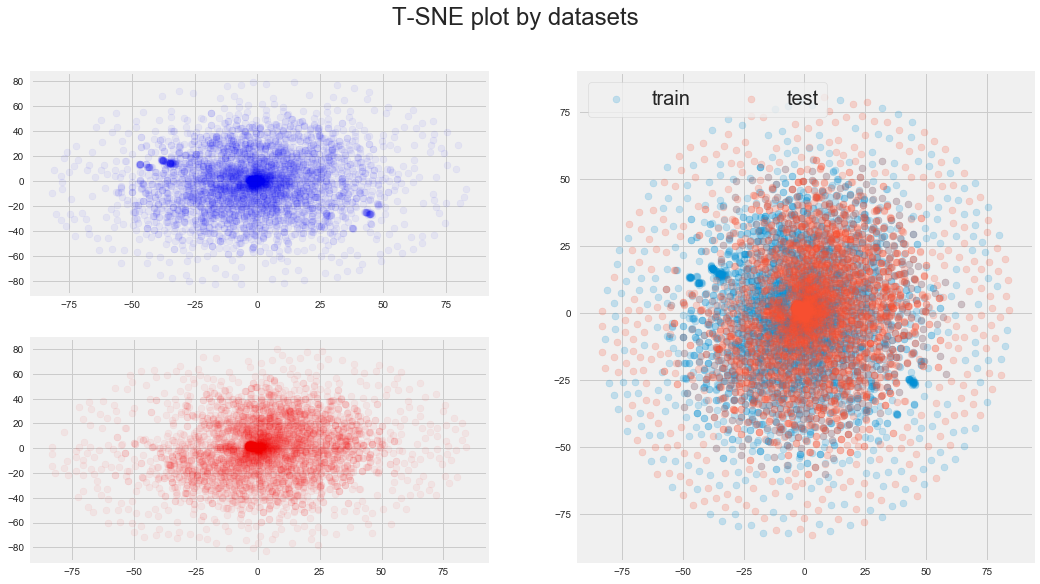

In [10]:
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['legend.fontsize'] = 20
plt.suptitle('T-SNE plot by datasets', fontsize=24)
ax1 = plt.subplot(221)
plt.scatter(Y[:4000, 0], Y[:4000, 1], c='b', alpha=0.05, label='train')
ax2 = plt.subplot(223)
plt.scatter(Y[4000:, 0], Y[4000:, 1], c='r', alpha=0.05, label='test')
plt.subplot(122)
plt.scatter(Y[:4000, 0], Y[:4000, 1], alpha=0.2, label='train')
plt.scatter(Y[4000:, 0], Y[4000:, 1], alpha=0.2, label='test')
plt.legend(ncol=2, frameon=True)    
plt.savefig('../Presentation/plot_tsne_on_raw_wav_PCA')
plt.show()
plt.close('all')

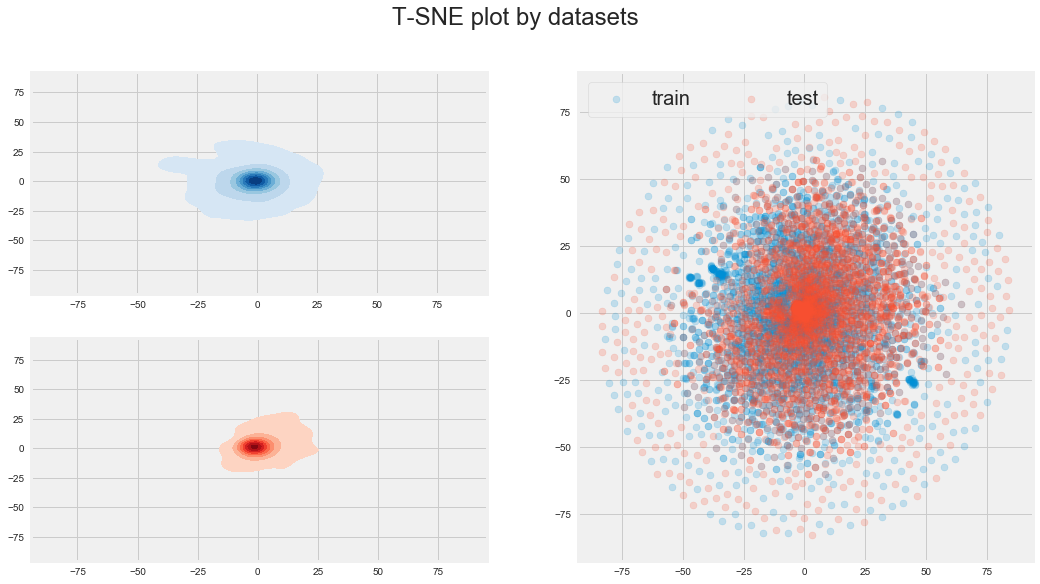

In [12]:
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['legend.fontsize'] = 20
plt.suptitle('T-SNE plot by datasets', fontsize=24)
ax1 = plt.subplot(221)
sns.kdeplot(Y[:4000, 0], Y[:4000, 1], cmap="Blues", shade=True, shade_lowest=False)
ax2 = plt.subplot(223)
sns.kdeplot(Y[4000:, 0], Y[4000:, 1], cmap="Reds", shade=True, shade_lowest=False)
plt.subplot(122)
plt.scatter(Y[:4000, 0], Y[:4000, 1], alpha=0.2, label='train')
plt.scatter(Y[4000:, 0], Y[4000:, 1], alpha=0.2, label='test')
plt.legend(ncol=2, frameon=True)    
plt.savefig('../Presentation/plot_tsne_and_kde_on_raw_wav_PCA.png')
plt.show()
plt.close('all')

In [13]:
d_train = np.array([
    read_mfcc('../input/train/audio/{}/{}'.format(row['label'], row['filename'])).flatten()
    for _, row in train_samples.iterrows()
])

d_test = np.array([
    read_mfcc('../input/test/audio/{}'.format(row['fname'])).flatten()
    for _, row in test_samples.iterrows()
])

In [14]:
%%time
pca = PCA(n_components=100, random_state=42).fit(d_train)
print(sum(pca.explained_variance_ratio_))
pcs = pca.transform(np.vstack([d_train, d_test]))

0.9852326090184187
CPU times: user 394 ms, sys: 94.2 ms, total: 489 ms
Wall time: 220 ms


In [15]:
%%time
tsne = TSNE(n_components=2, init='pca', n_iter=1000, verbose=1)
Y = tsne.fit_transform(pcs)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.020s...
[t-SNE] Computed neighbors for 8000 samples in 5.511s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.878059
[t-SNE] Error after 1000 iterations: 2.862056
CPU times: user 4min 46s, sys: 17 s, total: 5min 3s
Wall time: 5min 3s


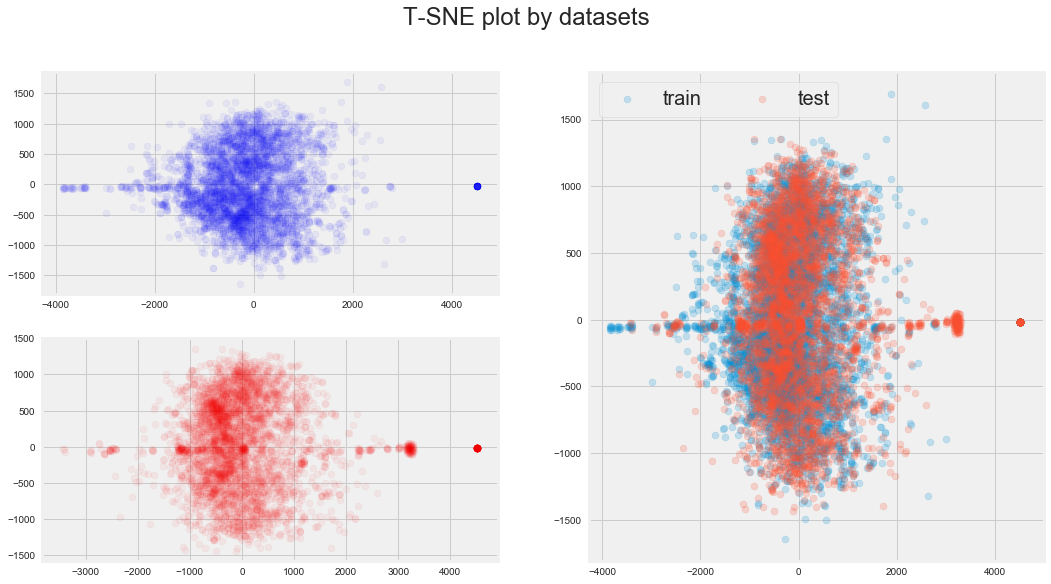

In [16]:
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['legend.fontsize'] = 20
plt.suptitle('T-SNE plot by datasets', fontsize=24)
ax1 = plt.subplot(221)
plt.scatter(Y[:4000, 0], Y[:4000, 1], c='b', alpha=0.05, label='train')
ax2 = plt.subplot(223)
plt.scatter(Y[4000:, 0], Y[4000:, 1], c='r', alpha=0.05, label='test')
plt.subplot(122)
plt.scatter(Y[:4000, 0], Y[:4000, 1], alpha=0.2, label='train')
plt.scatter(Y[4000:, 0], Y[4000:, 1], alpha=0.2, label='test')
plt.legend(ncol=2, frameon=True)    
plt.savefig('../Presentation/plot_tsne_on_mfcc_PCA.png')
plt.show()
plt.close('all')

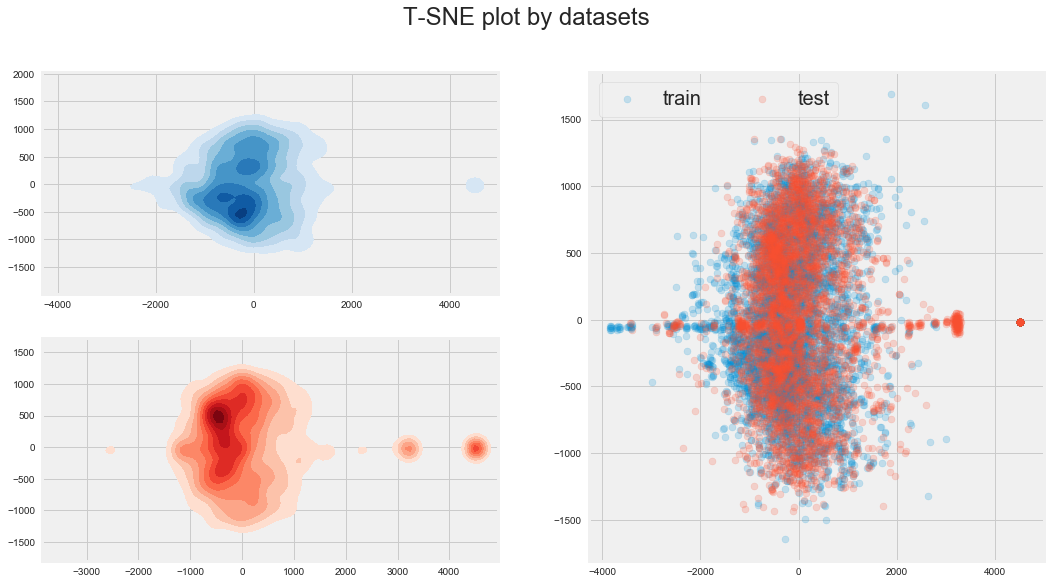

In [17]:
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['legend.fontsize'] = 20
plt.suptitle('T-SNE plot by datasets', fontsize=24)
ax1 = plt.subplot(221)
sns.kdeplot(Y[:4000, 0], Y[:4000, 1], cmap="Blues", shade=True, shade_lowest=False)
ax2 = plt.subplot(223)
sns.kdeplot(Y[4000:, 0], Y[4000:, 1], cmap="Reds", shade=True, shade_lowest=False)
plt.subplot(122)
plt.scatter(Y[:4000, 0], Y[:4000, 1], alpha=0.2, label='train')
plt.scatter(Y[4000:, 0], Y[4000:, 1], alpha=0.2, label='test')
plt.legend(ncol=2, frameon=True)    
plt.savefig('../Presentation/plot_tsne_and_kde_on_mfcc_PCA.png')
plt.show()
plt.close('all')

In [18]:
filename = test_samples.loc[pd.Series(Y[4000:, 0]).map(lambda x: 3000 < x < 4000).values]['fname'].sample().values[0]
IPython.display.Audio('../input/test/audio/{}'.format(filename))